In [78]:
#This is Good Practioce for the moment

!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
!pip install fsspec==2024.6.0 --force-reinstall --no-deps
!pip install opencv-python

  Using cached fsspec-2024.6.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.0-py3-none-any.whl (176 kB)


In [79]:
#install also to vizualize figures
!sudo apt-get update
!sudo apt-get install -y libgl1-mesa-glx
!sudo apt-get install -y libglib2.0-0

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                      
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.3).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [127]:
import os
import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

#Kaggle Files
rd = './kaggle-files'

df = pd.read_csv(f'{rd}/train.csv')

df = df.fillna(-100)
label2id = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
df = df.replace(label2id)

df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [128]:

# Load the coordinates data
old_coordinates_df = pd.read_csv(f'{rd}/train_label_coordinates.csv')


old_coordinates_df.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [129]:

# Load the coordinates data
coordinates_df = pd.read_csv(f'{rd}/dfc_updated.csv')
coordinates_df.head()

# Keep only rows where 'slice_number' is not NaN
coordinates_df = coordinates_df.dropna(subset=['slice_number'])
coordinates_df['slice_number'] = coordinates_df['slice_number'].astype(int)


In [130]:
print(coordinates_df['slice_number'].isna().sum())
total_rows = len(coordinates_df)
print(f"Total rows in coordinates_df: {total_rows}")
missing_slice_numbers = coordinates_df['slice_number'].isna().sum()
percentage_missing = (missing_slice_numbers / total_rows) * 100
print(f"Percentage of missing 'slice_number': {percentage_missing:.2f}%")



0
Total rows in coordinates_df: 36844
Percentage of missing 'slice_number': 0.00%


In [131]:
series_description_df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
series_description_df['series_description'] = series_description_df['series_description'].str.replace('T2/STIR', 'T2_STIR')
series_description_df.head()



,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2_STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [132]:
CONDITIONS = coordinates_df['condition'].unique()

LEVELS = coordinates_df['level'].unique()

SERIES_DESCRIPTIONS = ['Sagittal T1', 'Sagittal T2_STIR', 'Axial T2']

In [133]:
print(df.columns)
print(coordinates_df.columns)
print(series_description_df.columns)
print(CONDITIONS)
print(LEVELS)
print(SERIES_DESCRIPTIONS)

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

## BUilding the Dataloader

To summarize, the `dataloader` will:
- Load images from different series descriptions (e.g., 'Sagittal T1', 'Sagittal T2_STIR', 'Axial T2') for each `study_id`.
- Use the `coordinates_df` to access the `x`, `y` annotations for specific conditions and levels when available.
- Combine the information from `df` to create labels for the different conditions and levels.

### DataLoader Steps
1. **Load Images by Study**: For each `study_id`, load slices from each `series_description` into a tensor.
2. **Annotations**: Use `coordinates_df` to check if a condition has an associated `x`, `y` coordinate. If not, handle the absence gracefully.
3. **Label Extraction**: Use `df` to extract the condition-level labels for each study.
4. **Return Image and Labels**: Output images and labels, with a focus on condition-level features.


In [134]:
class LumbarSpineDataset(Dataset):
    def __init__(self, df, coordinates_df, series_description_df, root_dir, transform=None):
        self.df = df
        self.coordinates_df = coordinates_df
        self.series_description_df = series_description_df
        self.root_dir = root_dir  # The root directory where images are stored
        self.transform = transform
        
        # Get the list of study_ids
        self.study_ids = self.df['study_id'].unique()
        
        # Create a mapping from study_id to labels
        self.labels_dict = self.df.set_index('study_id').to_dict('index')
        
        # Prepare a mapping for images and annotations
        self.study_image_paths = self._prepare_image_paths()
        
    def _prepare_image_paths(self):
        study_image_paths = {}
        for study_id in self.study_ids:
            study_image_paths[study_id] = {}
            for series_description in SERIES_DESCRIPTIONS:
                series_description_clean = series_description.replace('/', '_')
                image_dir = os.path.join(self.root_dir, 'cvt_png', str(study_id), series_description_clean)
                if os.path.exists(image_dir):
                    # Get all images in the directory
                    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))
                    study_image_paths[study_id][series_description] = image_paths
                else:
                    # Handle missing series
                    study_image_paths[study_id][series_description] = []
        return study_image_paths
    
    def __len__(self):
        return len(self.study_ids)
    
    def __getitem__(self, idx):
        study_id = self.study_ids[idx]
        images = {}
        annotations = {}
        
        # Load images for each series description
        for series_description in SERIES_DESCRIPTIONS:
            image_paths = self.study_image_paths[study_id][series_description]
            series_images = []
            for img_path in image_paths:
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                if self.transform:
                    img = self.transform(img)
                series_images.append(img)
            if series_images:
                # Stack images along the depth dimension
                series_tensor = torch.stack(series_images, dim=0)  # Shape: [num_slices, H, W]
            else:
                # Handle missing images
                series_tensor = torch.zeros((1, 512, 512))  # Placeholder tensor
            images[series_description] = series_tensor
        
        # Get labels for the study_id
        labels = self.labels_dict[study_id]
        
        # Get annotations for the study_id
        study_annotations = self.coordinates_df[self.coordinates_df['study_id'] == study_id]
        for _, row in study_annotations.iterrows():
            condition = row['condition']
            level = row['level']
            x = row['x_scaled']
            y = row['y_scaled']
            series_description = row['series_description']
            slice_number = int(row['slice_number'])
            key = f"{condition}_{level}"
            if key not in annotations:
                annotations[key] = {}
            if series_description not in annotations[key]:
                annotations[key][series_description] = []
            annotations[key][series_description].append({
                'x': x,
                'y': y,
                'slice_number': slice_number
            })
        
        # Return a dictionary containing images, labels, and annotations
        sample = {
            'study_id': study_id,
            'images': images,
            'labels': labels,
            'annotations': annotations
        }
        
        return sample


In [135]:
    # def __getitem__(self, idx):
    #     study_id = self.study_ids[idx]
    #     images = []
    #     annotations = {}
        
    #     # Get annotations for the study_id
    #     study_annotations = self.coordinates_df[self.coordinates_df['study_id'] == study_id]
        
    #     for _, row in study_annotations.iterrows():
    #         condition = row['condition']
    #         level = row['level']
    #         x = row['x_scaled']
    #         y = row['y_scaled']
    #         series_description = row['series_description']
    #         slice_number = int(row['slice_number'])
    #         img_path = os.path.join(
    #             self.root_dir,
    #             'cvt_png',
    #             str(study_id),
    #             series_description.replace('/', '_'),
    #             f"{slice_number:03d}.png"
    #         )
    #         if os.path.exists(img_path):
    #             img = Image.open(img_path).convert('L')
    #             if self.transform:
    #                 img = self.transform(img)
    #             images.append(img)
    #             key = f"{condition}_{level}"
    #             if key not in annotations:
    #                 annotations[key] = []
    #             annotations[key].append({
    #                 'x': x,
    #                 'y': y,
    #                 'series_description': series_description,
    #                 'slice_number': slice_number
    #             })
        
    #     if images:
    #         images_tensor = torch.stack(images, dim=0)
    #     else:
    #         images_tensor = torch.zeros((1, 1, 512, 512))  # Placeholder
        
    #     labels = self.labels_dict[study_id]
        
    #     sample = {
    #         'study_id': study_id,
    #         'images': images_tensor,
    #         'labels': labels,
    #         'annotations': annotations
    #     }
        
    #     return sample


## Testing the dataloader

In [138]:
# Define any transformations if needed
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Instantiate the dataset
dataset = LumbarSpineDataset(
    df=df,
    coordinates_df=coordinates_df,
    series_description_df=series_description_df,
    root_dir='./rsna_output',  # Adjust the path as needed
    transform=transform
)

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Iterate through the DataLoader
for batch in data_loader:
    study_id = batch['study_id'][0]
    images = batch['images']
    labels = batch['labels']
    annotations = batch['annotations']
    
    print(f"Study ID: {study_id}")
    for series_description in images:
        print(f"Series Description: {series_description}")
        print(f"Image Tensor Shape: {images[series_description].shape}")
    print(f"Labels: {labels}")
    print(f"Annotations: {annotations}")
    break  # Remove this break to iterate through all batches


Study ID: 4003253
Series Description: Sagittal T1
Image Tensor Shape: torch.Size([1, 10, 1, 512, 512])
Series Description: Sagittal T2_STIR
Image Tensor Shape: torch.Size([1, 10, 1, 512, 512])
Series Description: Axial T2
Image Tensor Shape: torch.Size([1, 43, 1, 512, 512])
Labels: {'spinal_canal_stenosis_l1_l2': tensor([0]), 'spinal_canal_stenosis_l2_l3': tensor([0]), 'spinal_canal_stenosis_l3_l4': tensor([0]), 'spinal_canal_stenosis_l4_l5': tensor([0]), 'spinal_canal_stenosis_l5_s1': tensor([0]), 'left_neural_foraminal_narrowing_l1_l2': tensor([0]), 'left_neural_foraminal_narrowing_l2_l3': tensor([0]), 'left_neural_foraminal_narrowing_l3_l4': tensor([0]), 'left_neural_foraminal_narrowing_l4_l5': tensor([1]), 'left_neural_foraminal_narrowing_l5_s1': tensor([0]), 'right_neural_foraminal_narrowing_l1_l2': tensor([0]), 'right_neural_foraminal_narrowing_l2_l3': tensor([0]), 'right_neural_foraminal_narrowing_l3_l4': tensor([1]), 'right_neural_foraminal_narrowing_l4_l5': tensor([1]), 'right

Series Description: Sagittal T1
Image Tensor Shape: torch.Size([1, 10, 1, 512, 512])


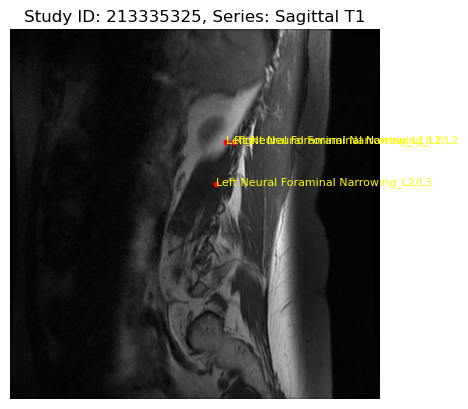

Series Description: Sagittal T2_STIR
Image Tensor Shape: torch.Size([1, 10, 1, 512, 512])


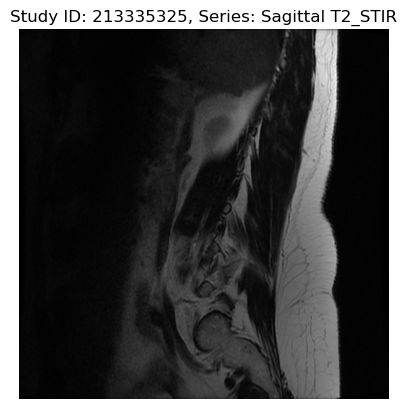

Series Description: Axial T2
Image Tensor Shape: torch.Size([1, 25, 1, 512, 512])


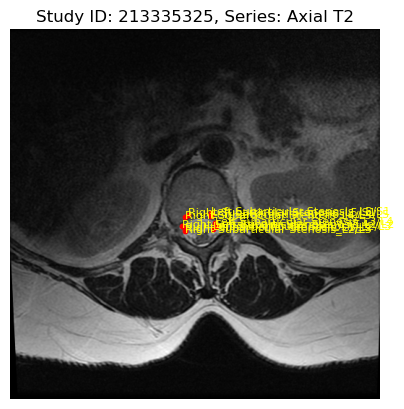

In [139]:
## Visualizing the data:
import matplotlib.pyplot as plt

study_index = 100

# Assuming you have a DataLoader, use iter() to create an iterator
data_iter = iter(data_loader)

# Skip to the nth batch (e.g., the first batch)
for _ in range(study_index):
    next(data_iter)

# Now get the batch
batch = next(data_iter)

images = batch['images']
annotations = batch['annotations']

# The 'images' variable is a dictionary where keys are series descriptions
# and values are tensors of shape [batch_size, num_slices, channels, H, W]

# Since your batch_size is 1, we can squeeze that dimension
for series_description, image_tensor in images.items():
    print(f"Series Description: {series_description}")
    print(f"Image Tensor Shape: {image_tensor.shape}")
    
    # Remove batch dimension
    image_tensor = image_tensor.squeeze(0)  # Shape: [num_slices, channels, H, W]
    
    # Let's visualize the first slice
    image = image_tensor[0]  # Shape: [channels, H, W]
    
    # Remove channel dimension if it's 1
    if image.shape[0] == 1:
        image = image.squeeze(0)  # Shape: [H, W]
    
    # Convert tensor to numpy array
    image_np = image.numpy()
    
    # Plot the image
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Study ID: {batch['study_id'][0]}, Series: {series_description}")
    plt.axis('off')
    
    # Plot annotations if any
    plt.scatter([], [])  # Initialize scatter plot
    for key in annotations:
        if series_description in annotations[key]:
            for ann in annotations[key][series_description]:
                x = ann['x'].item()
                y = ann['y'].item()
                plt.scatter(x, y, c='red', s=10)
                # Optionally, add labels for the annotations
                plt.text(x, y, key, fontsize=8, color='yellow')
    plt.show()



## Model Architecture Plan
1- Input: Three separate image tensors, each representing a different series, with multiple slices as channels.

2- Backbone: We will use a CNN backbone (e.g., ResNet, EfficientNet) to process each input tensor separately.

3- Attention Mechanism: If desired, we can add an attention mechanism to focus on important regions (annotations can be used for this during training).
4- Feature Fusion: After extracting features from each input, we will concatenate or combine them.

5- Final Layers: A series of fully connected layers to output predictions (e.g., classification for spinal conditions or severity).

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm

# Define the ResNet feature extractor
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, in_channels=3):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        # Modify the first convolutional layer to accept in_channels
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Extract layers up to layer4 (exclude avgpool and fc layers)
        self.features = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )

    def forward(self, x):
        x = self.features(x)
        return x  # Output shape: [batch_size, 512, H, W]


In [141]:
# Define the main model
class MultiSeriesSpineModel(nn.Module):
    def __init__(self, num_conditions=25, num_classes=3):
        super(MultiSeriesSpineModel, self).__init__()
        
        # Feature extractors for each MRI series
        self.cnn_sagittal_t1 = ResNetFeatureExtractor(in_channels=10)
        self.cnn_sagittal_t2_stir = ResNetFeatureExtractor(in_channels=10)
        self.cnn_axial_t2 = ResNetFeatureExtractor(in_channels=10)

        # Define attention layers for each series
        self.attention_sagittal_t1 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.attention_sagittal_t2_stir = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.attention_axial_t2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Define the final classification layers
        combined_feature_size = 512 * 3  # Since we're concatenating features from three models

        self.fc1 = nn.Linear(combined_feature_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, sagittal_t1, sagittal_t2_stir, axial_t2):
        # Forward pass through each ResNet18 model
        features_sagittal_t1 = self.cnn_sagittal_t1(sagittal_t1)  # Output shape: [batch_size, 512, H, W]
        features_sagittal_t2_stir = self.cnn_sagittal_t2_stir(sagittal_t2_stir)
        features_axial_t2 = self.cnn_axial_t2(axial_t2)

        # Generate attention maps
        attention_map_t1 = self.attention_sagittal_t1(features_sagittal_t1)  # Shape: [batch_size, 1, H, W]
        attention_map_t2_stir = self.attention_sagittal_t2_stir(features_sagittal_t2_stir)
        attention_map_axial = self.attention_axial_t2(features_axial_t2)

        # Apply attention
        features_sagittal_t1 = features_sagittal_t1 * attention_map_t1  # Element-wise multiplication
        features_sagittal_t2_stir = features_sagittal_t2_stir * attention_map_t2_stir
        features_axial_t2 = features_axial_t2 * attention_map_axial

        # Global average pooling
        features_sagittal_t1 = F.adaptive_avg_pool2d(features_sagittal_t1, (1, 1)).view(features_sagittal_t1.size(0), -1)
        features_sagittal_t2_stir = F.adaptive_avg_pool2d(features_sagittal_t2_stir, (1, 1)).view(features_sagittal_t2_stir.size(0), -1)
        features_axial_t2 = F.adaptive_avg_pool2d(features_axial_t2, (1, 1)).view(features_axial_t2.size(0), -1)

        # Concatenate features
        combined_features = torch.cat([features_sagittal_t1, features_sagittal_t2_stir, features_axial_t2], dim=1)

        # Pass through final classification layers
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)  # Output shape: [batch_size, num_classes]

        return x  # Return logits

In [143]:
# Resample slices function
# This functions in necessary because the number of slices on the axial images vary
def resample_slices(image_tensor, target_slices=10):
    """
    Resample the number of slices to match the target number of slices.
    """
    current_slices = image_tensor.shape[0]

    if current_slices == target_slices:
        return image_tensor  # No need to resample

    # If more slices, downsample to the target number
    if current_slices > target_slices:
        indices = torch.linspace(0, current_slices - 1, target_slices).long()
        return image_tensor[indices]

    # If fewer slices, upsample by interpolation
    image_tensor = image_tensor.permute(1, 0, 2, 3).unsqueeze(0)  # Shape: [1, channels, slices, H, W]
    image_tensor_resized = F.interpolate(
        image_tensor,
        size=(target_slices, image_tensor.shape[3], image_tensor.shape[4]),
        mode='trilinear',
        align_corners=False
    )
    return image_tensor_resized.squeeze(0).permute(1, 0, 2, 3)  # Shape: [slices, channels, H, W]

In [144]:
# Instantiate the model
model = MultiSeriesSpineModel()

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Assuming you have a DataLoader named train_loader
# Ensure that your Dataset and DataLoader are properly defined
# For example:
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [147]:
# Instantiate the dataset
train_dataset = LumbarSpineDataset(
    df=df,
    coordinates_df=coordinates_df,
    series_description_df=series_description_df,
    root_dir='./rsna_output',  # Adjust the path as needed
    transform=transform
)

# Create a DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=1,  # Adjust batch size as needed
    shuffle=True,
    num_workers=4,  # Adjust based on your system
    pin_memory=True
)

In [151]:
num_epochs = 10  # Define the number of epochs
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for batch in progress_bar:
        # Extract images and labels from the batch
        images = batch['images']
        labels = batch['labels']  # This is a dict

        # Get the image tensors
        sagittal_t1 = images['Sagittal T1'].squeeze(0)  # Shape: [num_slices, 1, H, W]
        sagittal_t2_stir = images['Sagittal T2_STIR'].squeeze(0)
        axial_t2 = images['Axial T2'].squeeze(0)

        # Resample slices to 10
        sagittal_t1 = resample_slices(sagittal_t1, target_slices=10)
        sagittal_t2_stir = resample_slices(sagittal_t2_stir, target_slices=10)
        axial_t2 = resample_slices(axial_t2, target_slices=10)

        # Prepare images for the model
        sagittal_t1 = sagittal_t1.view(1, -1, 512, 512).to(device)  # Shape: [1, 10, 512, 512]
        sagittal_t2_stir = sagittal_t2_stir.view(1, -1, 512, 512).to(device)
        axial_t2 = axial_t2.view(1, -1, 512, 512).to(device)

        # Prepare labels tensor
        labels_list = []
        for key in sorted(labels.keys()):
            value = labels[key]
            if isinstance(value, torch.Tensor):
                value = value.item()
            value = float(value)
            if value > 1.0:
                value = 1.0
            labels_list.append(value)
        labels_tensor = torch.tensor(labels_list, dtype=torch.float32).to(device)  # Shape: [num_classes]

        # Add batch dimension to labels_tensor
        labels_tensor = labels_tensor.unsqueeze(0)  # Shape: [1, num_classes]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sagittal_t1, sagittal_t2_stir, axial_t2)  # outputs shape: [1, num_classes]

        # Compute loss
        total_loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Update loss
        epoch_loss += total_loss.item()

        # Update progress bar
        progress_bar.set_postfix({'Loss': f'{total_loss.item():.4f}'})

    # Epoch summary
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")


Epoch 1/10:   0%|          | 0/1975 [00:00<?, ?batch/s]


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
#try normalize


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10:   0%|          | 0/1975 [00:00<?, ?batch/s]


ValueError: Target size (torch.Size([1, 1, 25])) must be the same as input size (torch.Size([1, 25]))

In [153]:
# Set the root directory for your Kaggle files
rd = './kaggle-files'

# Load the main CSV file
df = pd.read_csv(f'{rd}/train.csv')
df = df.fillna(-100)  # Use -100 to indicate missing labels

# Map the labels to integers for multi-class classification
label2id = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
df.replace(label2id, inplace=True)

# Load the coordinates data
coordinates_df = pd.read_csv(f'{rd}/dfc_updated.csv')
# Keep only rows where 'slice_number' is not NaN
coordinates_df = coordinates_df.dropna(subset=['slice_number'])
coordinates_df['slice_number'] = coordinates_df['slice_number'].astype(int)

# Load the series descriptions
series_description_df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
series_description_df['series_description'] = series_description_df['series_description'].str.replace('T2/STIR', 'T2_STIR')

# Define constants
SERIES_DESCRIPTIONS = ['Sagittal T1', 'Sagittal T2_STIR', 'Axial T2']


In [154]:
class LumbarSpineDataset(Dataset):
    def __init__(self, df, coordinates_df, series_description_df, root_dir, transform=None):
        self.df = df
        self.coordinates_df = coordinates_df
        self.series_description_df = series_description_df
        self.root_dir = root_dir  # The root directory where images are stored
        self.transform = transform

        # Get the list of study_ids
        self.study_ids = self.df['study_id'].unique()

        # List of label columns (assuming all columns except 'study_id' are labels)
        self.label_columns = [col for col in df.columns if col != 'study_id']

        # Prepare a mapping for images and annotations
        self.study_image_paths = self._prepare_image_paths()

        # Create a mapping from study_id to labels
        self.labels_dict = self._prepare_labels()

    def _prepare_image_paths(self):
        study_image_paths = {}
        for study_id in self.study_ids:
            study_image_paths[study_id] = {}
            for series_description in SERIES_DESCRIPTIONS:
                series_description_clean = series_description.replace('/', '_')
                image_dir = os.path.join(self.root_dir, 'cvt_png', str(study_id), series_description_clean)
                if os.path.exists(image_dir):
                    # Get all images in the directory
                    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')))
                    study_image_paths[study_id][series_description] = image_paths
                else:
                    # Handle missing series
                    study_image_paths[study_id][series_description] = []
        return study_image_paths

    def _prepare_labels(self):
        labels_dict = {}
        for idx, row in self.df.iterrows():
            study_id = row['study_id']
            labels = []
            for col in self.label_columns:
                label = row[col]
                if pd.isnull(label) or label == -100:
                    label = -100  # Use -100 for missing labels (ignore_index)
                else:
                    label = int(label)
                labels.append(label)
            labels_dict[study_id] = labels
        return labels_dict

    def __len__(self):
        return len(self.study_ids)

    def __getitem__(self, idx):
        study_id = self.study_ids[idx]
        images = {}
        annotations = {}

        # Load images for each series description
        for series_description in SERIES_DESCRIPTIONS:
            image_paths = self.study_image_paths[study_id][series_description]
            series_images = []
            for img_path in image_paths:
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                if self.transform:
                    img = self.transform(img)
                series_images.append(img)
            if series_images:
                # Stack images along the depth dimension
                series_tensor = torch.stack(series_images, dim=0)  # Shape: [num_slices, 1, H, W]
            else:
                # Handle missing images
                series_tensor = torch.zeros((1, 1, 512, 512))  # Placeholder tensor
            images[series_description] = series_tensor

        # Get labels for the study_id
        labels = self.labels_dict[study_id]
        labels_tensor = torch.tensor(labels, dtype=torch.long)  # Use long dtype for CrossEntropyLoss

        # Get annotations for the study_id (if needed)
        study_annotations = self.coordinates_df[self.coordinates_df['study_id'] == study_id]
        for _, row in study_annotations.iterrows():
            condition = row['condition']
            level = row['level']
            x = row['x_scaled']
            y = row['y_scaled']
            series_description = row['series_description']
            slice_number = int(row['slice_number'])
            key = f"{condition}_{level}"
            if key not in annotations:
                annotations[key] = {}
            if series_description not in annotations[key]:
                annotations[key][series_description] = []
            annotations[key][series_description].append({
                'x': x,
                'y': y,
                'slice_number': slice_number
            })

        # Return a dictionary containing images, labels, and annotations
        sample = {
            'study_id': study_id,
            'images': images,
            'labels': labels_tensor,
            'annotations': annotations
        }

        return sample


In [155]:
# Define any transformations if needed
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust mean and std if necessary
])

# Instantiate the dataset
train_dataset = LumbarSpineDataset(
    df=df,
    coordinates_df=coordinates_df,
    series_description_df=series_description_df,
    root_dir='./rsna_output',  # Adjust the path as needed
    transform=transform
)

# Create a DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=1,  # Adjust batch size as needed
    shuffle=True,
    num_workers=4,  # Adjust based on your system
    pin_memory=True
)


In [156]:
# Define the ResNet feature extractor
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, in_channels=10):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        # Modify the first convolutional layer to accept in_channels
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Extract layers up to layer4 (exclude avgpool and fc layers)
        self.features = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )

    def forward(self, x):
        x = self.features(x)
        return x  # Output shape: [batch_size, 512, H, W]

# Define the main model
class MultiSeriesSpineModel(nn.Module):
    def __init__(self, num_conditions=25, num_classes=3):
        super(MultiSeriesSpineModel, self).__init__()

        # Feature extractors for each MRI series
        self.cnn_sagittal_t1 = ResNetFeatureExtractor(in_channels=10)
        self.cnn_sagittal_t2_stir = ResNetFeatureExtractor(in_channels=10)
        self.cnn_axial_t2 = ResNetFeatureExtractor(in_channels=10)

        # Define attention layers for each series
        self.attention_sagittal_t1 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.attention_sagittal_t2_stir = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.attention_axial_t2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Define the final classification layers
        combined_feature_size = 512 * 3  # Since we're concatenating features from three models

        self.fc1 = nn.Linear(combined_feature_size, 512)
        self.fc2 = nn.Linear(512, num_conditions * num_classes)  # Output layer

    def forward(self, sagittal_t1, sagittal_t2_stir, axial_t2):
        # Forward pass through each ResNet18 model
        features_sagittal_t1 = self.cnn_sagittal_t1(sagittal_t1)  # Shape: [batch_size, 512, H, W]
        features_sagittal_t2_stir = self.cnn_sagittal_t2_stir(sagittal_t2_stir)
        features_axial_t2 = self.cnn_axial_t2(axial_t2)

        # Generate attention maps
        attention_map_t1 = self.attention_sagittal_t1(features_sagittal_t1)  # Shape: [batch_size, 1, H, W]
        attention_map_t2_stir = self.attention_sagittal_t2_stir(features_sagittal_t2_stir)
        attention_map_axial = self.attention_axial_t2(features_axial_t2)

        # Apply attention
        features_sagittal_t1 = features_sagittal_t1 * attention_map_t1  # Element-wise multiplication
        features_sagittal_t2_stir = features_sagittal_t2_stir * attention_map_t2_stir
        features_axial_t2 = features_axial_t2 * attention_map_axial

        # Global average pooling
        features_sagittal_t1 = F.adaptive_avg_pool2d(features_sagittal_t1, (1, 1)).view(features_sagittal_t1.size(0), -1)
        features_sagittal_t2_stir = F.adaptive_avg_pool2d(features_sagittal_t2_stir, (1, 1)).view(features_sagittal_t2_stir.size(0), -1)
        features_axial_t2 = F.adaptive_avg_pool2d(features_axial_t2, (1, 1)).view(features_axial_t2.size(0), -1)

        # Concatenate features
        combined_features = torch.cat([features_sagittal_t1, features_sagittal_t2_stir, features_axial_t2], dim=1)

        # Pass through final classification layers
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)  # Shape: [batch_size, num_conditions * num_classes]
        x = x.view(-1, num_conditions, num_classes)  # Reshape to [batch_size, num_conditions, num_classes]
        return x  # Return logits


In [157]:
# Resample slices function
def resample_slices(image_tensor, target_slices=10):
    """
    Resample the number of slices to match the target number of slices.
    """
    current_slices = image_tensor.shape[0]

    if current_slices == target_slices:
        return image_tensor  # No need to resample

    # If more slices, downsample to the target number
    if current_slices > target_slices:
        indices = torch.linspace(0, current_slices - 1, target_slices).long()
        return image_tensor[indices]

    # If fewer slices, upsample by interpolation
    image_tensor = image_tensor.permute(1, 0, 2, 3).unsqueeze(0)  # Shape: [1, channels, slices, H, W]
    image_tensor_resized = F.interpolate(
        image_tensor,
        size=(target_slices, image_tensor.shape[3], image_tensor.shape[4]),
        mode='trilinear',
        align_corners=False
    )
    return image_tensor_resized.squeeze(0).permute(1, 0, 2, 3)  # Shape: [slices, channels, H, W]


In [160]:
# Instantiate the model
num_conditions = len(train_dataset.label_columns)
num_classes = 3
model = MultiSeriesSpineModel(num_conditions=num_conditions, num_classes=num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Use ignore_index to ignore missing labels
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [161]:
# Training loop
num_epochs = 10  # Define the number of epochs
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for batch in progress_bar:
        # Extract images and labels from the batch
        images = batch['images']
        labels = batch['labels']  # Tensor of shape [num_conditions]

        # Get the image tensors
        sagittal_t1 = images['Sagittal T1'].squeeze(0)  # Shape: [num_slices, 1, H, W]
        sagittal_t2_stir = images['Sagittal T2_STIR'].squeeze(0)
        axial_t2 = images['Axial T2'].squeeze(0)

        # Resample slices to 10
        sagittal_t1 = resample_slices(sagittal_t1, target_slices=10)
        sagittal_t2_stir = resample_slices(sagittal_t2_stir, target_slices=10)
        axial_t2 = resample_slices(axial_t2, target_slices=10)

        # Remove singleton channel dimension if present
        sagittal_t1 = sagittal_t1.squeeze(1)  # Shape: [10, H, W]
        sagittal_t2_stir = sagittal_t2_stir.squeeze(1)
        axial_t2 = axial_t2.squeeze(1)

        # Add batch dimension and move to device
        sagittal_t1 = sagittal_t1.unsqueeze(0).to(device)  # Shape: [1, 10, H, W]
        sagittal_t2_stir = sagittal_t2_stir.unsqueeze(0).to(device)
        axial_t2 = axial_t2.unsqueeze(0).to(device)

        # Prepare labels tensor and move to device
        labels_tensor = labels.unsqueeze(0).to(device)  # Shape: [1, num_conditions]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sagittal_t1, sagittal_t2_stir, axial_t2)  # Shape: [1, num_conditions, num_classes]

        # Reshape outputs and labels
        outputs = outputs.view(-1, num_classes)       # Shape: [num_conditions, num_classes]
        labels_tensor = labels_tensor.view(-1)        # Shape: [num_conditions]

        # Compute loss
        total_loss = criterion(outputs, labels_tensor)

        # Backward pass
        total_loss.backward()

        # Optimizer step
        optimizer.step()

        # Update loss
        epoch_loss += total_loss.item()

        # Update progress bar
        progress_bar.set_postfix({'Loss': f'{total_loss.item():.4f}'})

    # Epoch summary
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")


Epoch 1/10: 100%|██████████| 1975/1975 [02:53<00:00, 11.40batch/s, Loss=0.2905]


Epoch [1/10] Average Loss: 0.6121


Epoch 2/10: 100%|██████████| 1975/1975 [02:32<00:00, 12.91batch/s, Loss=0.1861]


Epoch [2/10] Average Loss: 0.5332


Epoch 3/10: 100%|██████████| 1975/1975 [02:31<00:00, 12.99batch/s, Loss=0.6627]


Epoch [3/10] Average Loss: 0.4882


Epoch 4/10: 100%|██████████| 1975/1975 [02:31<00:00, 13.04batch/s, Loss=0.5920]


Epoch [4/10] Average Loss: 0.4657


Epoch 5/10: 100%|██████████| 1975/1975 [02:30<00:00, 13.10batch/s, Loss=0.2392]


Epoch [5/10] Average Loss: 0.4502


Epoch 6/10: 100%|██████████| 1975/1975 [02:31<00:00, 13.04batch/s, Loss=0.0558]


Epoch [6/10] Average Loss: 0.4361


Epoch 7/10: 100%|██████████| 1975/1975 [02:33<00:00, 12.86batch/s, Loss=0.4477]


Epoch [7/10] Average Loss: 0.4210


Epoch 8/10: 100%|██████████| 1975/1975 [02:32<00:00, 12.94batch/s, Loss=0.3892]


Epoch [8/10] Average Loss: 0.4048


Epoch 9/10: 100%|██████████| 1975/1975 [02:31<00:00, 12.99batch/s, Loss=0.3627]


Epoch [9/10] Average Loss: 0.3890


Epoch 10/10: 100%|██████████| 1975/1975 [02:31<00:00, 13.03batch/s, Loss=0.3760]

Epoch [10/10] Average Loss: 0.3751


In [162]:
# Save the trained model's state_dict
model_save_path = 'multi_series_spine_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to multi_series_spine_model.pth



### Objective:
We want to plot an annotated axial slice image from our dataset. The annotations come from the `coordinates_df`, which contains x, y coordinates and additional information about the study, including the `series_id`, `instance_number`, `condition`, and `level`. These annotations represent the specific slices and the associated condition-level severity we're trying to classify/estimate.

### Key Points:
1. **Data Sources**:
   - **`df`**: This contains the labels for `condition` and `level` across different spinal areas for each `study_id`.
   - **`coordinates_df`**: This contains the x, y coordinates, `series_id`, `instance_number`, `condition`, and `level` related to each `study_id`.
   - **`series_description_df`**: This maps the `series_id` to its respective `series_description` (e.g., 'Axial T2', 'Sagittal T1').

2. **Image Path Mapping**:
   - From `coordinates_df`, we need to extract the `study_id`, `series_id`, and `instance_number` to locate the corresponding axial image. 
   - The image path is generated using:
     ```python
     image_path = f'./rsna_output/cvt_png/{study_id}/{series_description}/{instance_number:03d}.png'
     ```
     where `series_description` is derived from the `series_id` using the `series_description_df`.

3. **DataLoader Responsibilities**:
   - The DataLoader needs to provide the required information (`study_id`, `series_id`, `instance_number`, `x`, `y`) to correctly map images and annotations.
   - For slices without annotations, the model should focus on 'no annotation' data.

### Process Flow:
1. **Fetch Image and Annotations**:
   - For each study (`study_id`), find the `x`, `y` coordinates from `coordinates_df`.
   - Get the corresponding `series_id` and map it to a `series_description` using `series_description_df`.
   - Locate the slice image using `series_description` and `instance_number`.

2. **Plotting**:
   - Display the axial slice image with a bounding box drawn around the `x`, `y` coordinates for the annotation.
   - Display the label for the corresponding `condition` and `level`.



In [ ]:
# from torchviz import make_dot
# from PIL import Image
# import matplotlib.pyplot as plt

# # Create dummy data to simulate model input
# batch_size = 2
# dummy_sagittal_t1 = torch.randn(batch_size, 10, 512, 512)  # 10 slices for Sagittal T1
# dummy_sagittal_t2_stir = torch.randn(batch_size, 10, 512, 512)  # 10 slices for Sagittal T2/STIR
# dummy_axial_t2 = torch.randn(batch_size, 10, 512, 512)  # 10 slices for Axial T2

# # Pass through the model to get a forward pass
# condition_pred, coord_pred = model(dummy_sagittal_t1, dummy_sagittal_t2_stir, dummy_axial_t2)

# # Create the computational graph
# dot = make_dot((condition_pred, coord_pred), params=dict(model.named_parameters()))

# # Render to a file and display it
# dot.render("model_diagram", format="png")  # Save as PNG

# # Load and display the image
# img = Image.open("model_diagram.png")
# plt.figure(figsize=(10, 10))  # Increase the figure size for better clarity
# plt.imshow(img)
# plt.axis('off')  # Hide axes for clarity
# plt.show()